In [ ]:
# The link for the AI chat: https://gemini.google.com/share/2fda3084b5e7

--- Genre Analysis: Fisher's Exact Test Results ---

Genre           | Win Rate   | P-Value    | Result (alpha=0.05)
-----------------------------------------------------------------
Western         | 50.0%     | 0.1107     | Fail to Reject H0
Mystery         | 0.0%     | 0.2192     | Fail to Reject H0
Thriller        | 22.6%     | 0.2729     | Fail to Reject H0
Music           | 0.0%     | 0.3598     | Fail to Reject H0
Musical         | 33.3%     | 0.3925     | Fail to Reject H0
Sport           | 20.0%     | 0.5663     | Fail to Reject H0
History         | 18.5%     | 0.5717     | Fail to Reject H0
Crime           | 18.2%     | 0.5994     | Fail to Reject H0
Drama           | 15.8%     | 0.6959     | Fail to Reject H0
Fantasy         | 8.3%     | 0.6968     | Fail to Reject H0
Action          | 10.5%     | 0.7437     | Fail to Reject H0
Adventure       | 11.1%     | 0.7732     | Fail to Reject H0
Comedy          | 13.2%     | 0.8058     | Fail to Reject H0
Romance         | 16.3%    

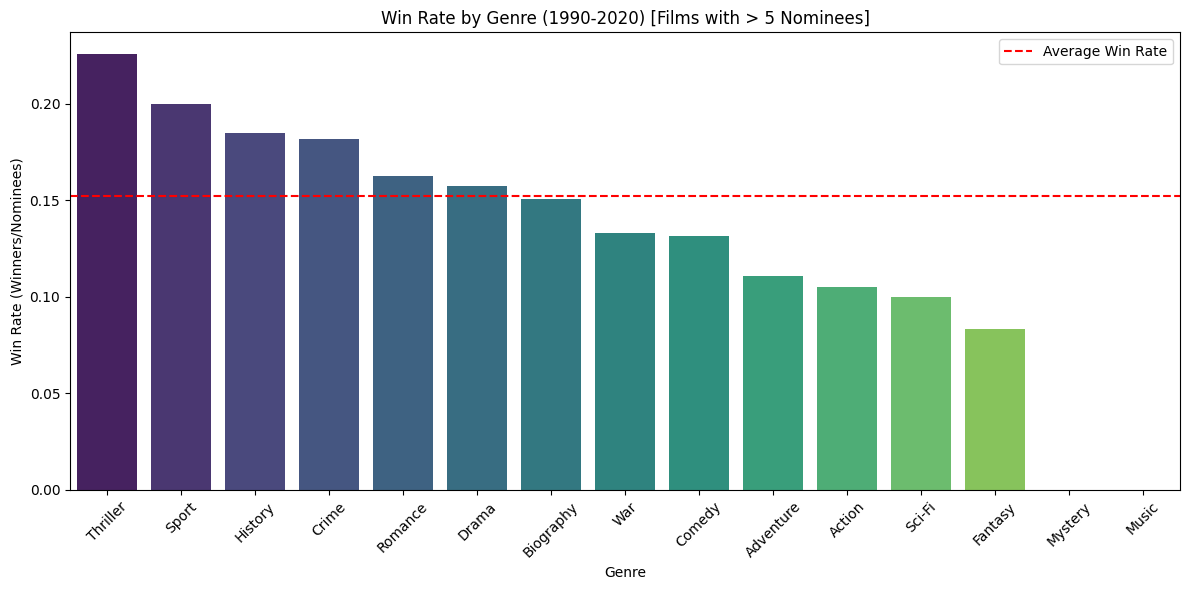

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
import io
import warnings

# --- 0. Setup & Warning Suppression ---
# This ignores FutureWarning messages like the one you encountered
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- 1. Data Loading and Cleaning ---
try:
    with open('Final_best_picture_data.csv', 'r') as f:
        lines = f.readlines()

    cleaned_lines = []
    for line in lines:
        line = line.strip()
        if not line: continue
        # Handle rows wrapped entirely in quotes to fix CSV parsing
        if line.startswith('"') and line.endswith('"'):
            content = line[1:-1].replace('""', '"') # Remove outer quotes and unescape inner
            cleaned_lines.append(content)
        else:
            cleaned_lines.append(line)

    # Create DataFrame from cleaned string content
    df = pd.read_csv(io.StringIO("\n".join(cleaned_lines)))
except FileNotFoundError:
    print("Error: 'Final_best_picture_data.csv' not found. Please upload the file.")
    df = pd.DataFrame()

if not df.empty:
    # --- 2. Preprocessing ---
    # Convert year and winner columns to correct types
    df['year_film'] = pd.to_numeric(df['year_film'], errors='coerce')
    df['winner'] = df['winner'].astype(str).str.lower() == 'true'

    # Filter for the training period specified in the proposal (1990-2020)
    df_analysis = df[(df['year_film'] >= 1990) & (df['year_film'] <= 2020)].copy()

    # Process Genres (split comma-separated strings into lists)
    df_analysis['Genre_List'] = df_analysis['Genre'].astype(str).str.split(',')
    df_analysis['Genre_List'] = df_analysis['Genre_List'].apply(lambda x: [g.strip() for g in x])

    # --- 3. Fisher's Exact Test Analysis ---
    # Get set of all unique genres present in the dataset
    all_genres = set([g for sublist in df_analysis['Genre_List'] for g in sublist])
    results = []

    print("--- Genre Analysis: Fisher's Exact Test Results ---\n")
    print(f"{'Genre':<15} | {'Win Rate':<10} | {'P-Value':<10} | {'Result (alpha=0.05)'}")
    print("-" * 65)

    for genre in all_genres:
        # Create binary feature for the current genre
        df_analysis[f'is_{genre}'] = df_analysis['Genre_List'].apply(lambda x: genre in x)

        # Contingency Table Construction
        #           Win   Not Win
        # Has Genre  a      b
        # No Genre   c      d
        has_genre_winners = len(df_analysis[(df_analysis[f'is_{genre}']) & (df_analysis['winner'])])
        has_genre_losers = len(df_analysis[(df_analysis[f'is_{genre}']) & (~df_analysis['winner'])])
        no_genre_winners = len(df_analysis[(~df_analysis[f'is_{genre}']) & (df_analysis['winner'])])
        no_genre_losers = len(df_analysis[(~df_analysis[f'is_{genre}']) & (~df_analysis['winner'])])

        table = [[has_genre_winners, has_genre_losers],
                 [no_genre_winners, no_genre_losers]]

        # Perform Fisher's Exact Test
        odds_ratio, p_value = fisher_exact(table, alternative='two-sided')

        # Calculate stats for reporting
        total_in_genre = has_genre_winners + has_genre_losers
        win_rate = has_genre_winners / total_in_genre if total_in_genre > 0 else 0

        # Determine conclusion text based on p-value
        conclusion = "REJECT H0" if p_value < 0.05 else "Fail to Reject H0"

        results.append({
            'Genre': genre,
            'P-Value': p_value,
            'Odds Ratio': odds_ratio,
            'Win Rate': win_rate,
            'Total Films': total_in_genre,
            'Conclusion': conclusion
        })

    # Convert results to DataFrame for sorting and easier plotting
    results_df = pd.DataFrame(results).sort_values(by='P-Value')

    # Print table rows (sorted by significance)
    for index, row in results_df.iterrows():
        print(f"{row['Genre']:<15} | {row['Win Rate']:.1%}     | {row['P-Value']:.4f}     | {row['Conclusion']}")

    # --- 4. Conclusion Printing ---
    print("\n" + "="*30)
    print("FINAL CONCLUSION FOR GENRE ANALYSIS")
    print("="*30)
    print("Null Hypothesis (H0): The genre of a film has no statistically significant effect on its chance of winning Best Picture.")
    print("Alternative Hypothesis (Ha): Some genres are significantly more likely to win than others.\n")

    significant_genres = results_df[results_df['P-Value'] < 0.05]

    if len(significant_genres) > 0:
        print("We REJECT the Null Hypothesis for the following genres:")
        for idx, row in significant_genres.iterrows():
            print(f"- {row['Genre']} (p={row['P-Value']:.4f})")
        print("\nThese genres show a statistically significant association with winning/losing.")
    else:
        print("We FAIL TO REJECT the Null Hypothesis for ALL genres at the 0.05 significance level, indicating the genre of a film has no statistically significant effect on its chance of winning Best Picture.")
        print("This suggests that, among the nominees, no specific genre guarantees a win or loss statistically.")
        print("Interpretation: Most nominees are Dramas, making genre a poor differentiator for predicting the winner.")

    # --- 5. Visualization (UPDATED) ---
    # Filter for genres with reasonable sample size (> 5 films)
    viz_df = results_df[results_df['Total Films'] >= 5].sort_values(by='Win Rate', ascending=False)

    plt.figure(figsize=(12, 6))

    # FIXED LINE: Added hue='Genre' and legend=False to fix the warning
    sns.barplot(data=viz_df, x='Genre', y='Win Rate', hue='Genre', palette='viridis', legend=False)

    plt.title('Win Rate by Genre (1990-2020) [Films with > 5 Nominees]')
    plt.xticks(rotation=45)
    plt.ylabel('Win Rate (Winners/Nominees)')

    # Add a line for the average win rate
    plt.axhline(y=df_analysis['winner'].mean(), color='r', linestyle='--', label='Average Win Rate')
    plt.legend() # This legend is for the red line

    plt.tight_layout()
    plt.show()

PART 1: RUNTIME T-TEST (Winners vs Non-Winners)
Winners Mean Runtime: 137.77 min
Losers Mean Runtime:  129.78 min
Difference:           7.98 min
T-Statistic:          1.5169
P-Value:              0.1379
CONCLUSION: FAIL TO REJECT H0. There is NO statistically significant difference in runtime.


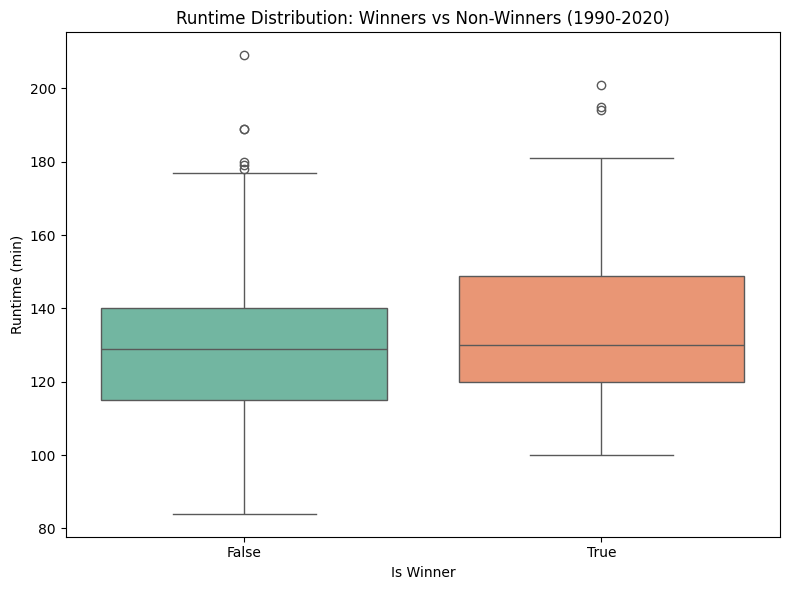


PART 2: BINNED RUNTIME ANALYSIS (10-min Intervals)
Note: Using Fisher's Exact Test to check if specific runtime ranges are predictive.
Bin Range       | Win Rate   | P-Value    | Result
-----------------------------------------------------------------
[80, 90)        | 0.0%     | 1.0000     | Fail to Reject
[90, 100)       | 0.0%     | 0.2244     | Fail to Reject
[100, 110)      | 5.3%     | 0.3176     | Fail to Reject
[110, 120)      | 20.7%     | 0.4021     | Fail to Reject
[120, 130)      | 18.4%     | 0.6151     | Fail to Reject
[130, 140)      | 15.6%     | 1.0000     | Fail to Reject
[140, 150)      | 7.1%     | 0.6992     | Fail to Reject
[150, 160)      | 14.3%     | 1.0000     | Fail to Reject
[160, 170)      | 10.0%     | 1.0000     | Fail to Reject
[170, 180)      | 16.7%     | 1.0000     | Fail to Reject
[180, 190)      | 25.0%     | 0.4864     | Fail to Reject
[190, 200)      | 100.0%     | 0.0225     | REJECT H0
[200, 210)      | 50.0%     | 0.2820     | Fail to Reject


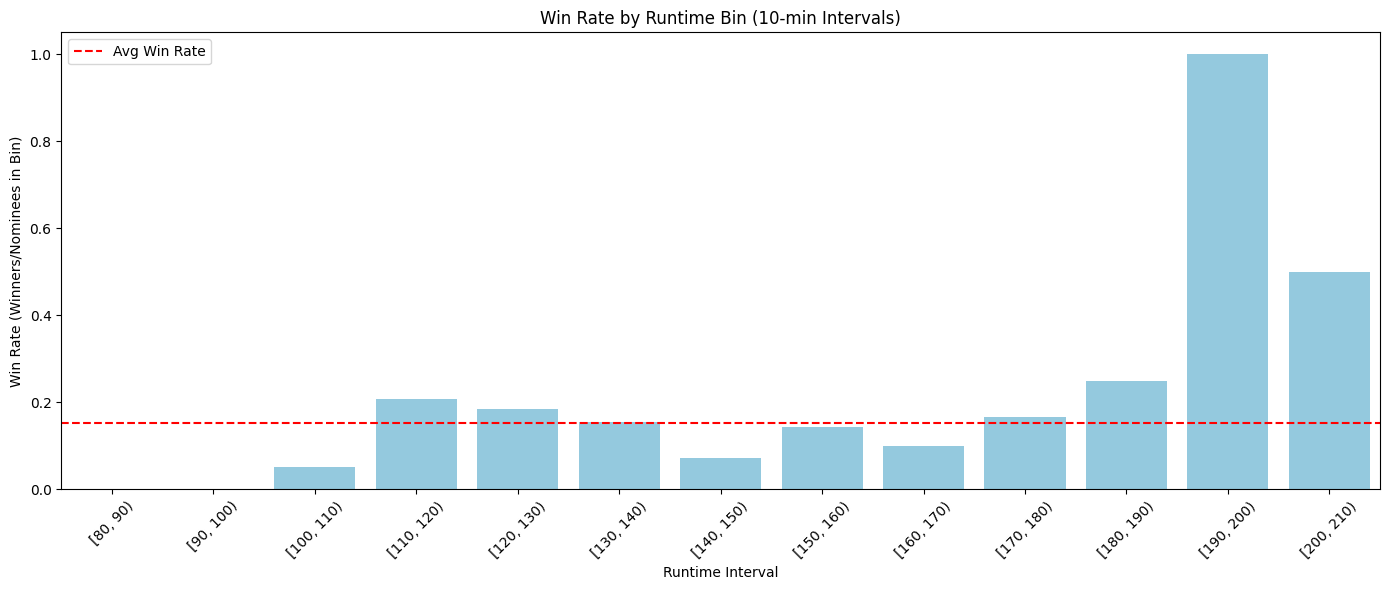

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, fisher_exact
import io
import warnings

# --- 0. Setup ---
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# --- 1. Data Loading and Cleaning ---
# Handle potentially messy CSV lines manually
try:
    with open('Final_best_picture_data.csv', 'r') as f:
        lines = f.readlines()

    cleaned_lines = []
    for line in lines:
        line = line.strip()
        if not line: continue
        # Handle rows wrapped entirely in quotes
        if line.startswith('"') and line.endswith('"'):
            content = line[1:-1].replace('""', '"')
            cleaned_lines.append(content)
        else:
            cleaned_lines.append(line)

    df = pd.read_csv(io.StringIO("\n".join(cleaned_lines)))
except FileNotFoundError:
    print("Error: 'Final_best_picture_data.csv' not found.")
    df = pd.DataFrame()

if not df.empty:
    # Preprocessing
    df['year_film'] = pd.to_numeric(df['year_film'], errors='coerce')
    df['winner'] = df['winner'].astype(str).str.lower() == 'true'

    # Filter for the project period (1990-2020)
    df_analysis = df[(df['year_film'] >= 1990) & (df['year_film'] <= 2020)].copy()

    # Parse Runtime (e.g., "142 min" -> 142)
    df_analysis['Runtime_Num'] = df_analysis['Runtime'].astype(str).str.replace(' min', '', regex=False)
    df_analysis['Runtime_Num'] = pd.to_numeric(df_analysis['Runtime_Num'], errors='coerce')

    # Drop rows where Runtime is NaN
    df_analysis = df_analysis.dropna(subset=['Runtime_Num'])

    # --- 2. T-Test Analysis (Winners vs Non-Winners) ---
    winners_runtime = df_analysis[df_analysis['winner']]['Runtime_Num']
    losers_runtime = df_analysis[~df_analysis['winner']]['Runtime_Num']

    # Perform Independent T-Test (assuming unequal variance)
    t_stat, p_val_ttest = ttest_ind(winners_runtime, losers_runtime, equal_var=False)

    print("==================================================")
    print("PART 1: RUNTIME T-TEST (Winners vs Non-Winners)")
    print("==================================================")
    print(f"Winners Mean Runtime: {winners_runtime.mean():.2f} min")
    print(f"Losers Mean Runtime:  {losers_runtime.mean():.2f} min")
    print(f"Difference:           {winners_runtime.mean() - losers_runtime.mean():.2f} min")
    print(f"T-Statistic:          {t_stat:.4f}")
    print(f"P-Value:              {p_val_ttest:.4f}")

    if p_val_ttest < 0.05:
        print("CONCLUSION: REJECT H0. There IS a statistically significant difference in runtime.")
    else:
        print("CONCLUSION: FAIL TO REJECT H0. There is NO statistically significant difference in runtime.")

    # Visualization 1: Boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='winner', y='Runtime_Num', data=df_analysis, palette='Set2')
    plt.title('Runtime Distribution: Winners vs Non-Winners (1990-2020)')
    plt.xlabel('Is Winner')
    plt.ylabel('Runtime (min)')
    plt.tight_layout()
    plt.show()

    # --- 3. Binned Analysis (10-min Intervals) ---
    # Create bins dynamically based on min/max runtime
    min_r = int(df_analysis['Runtime_Num'].min())
    max_r = int(df_analysis['Runtime_Num'].max())

    # Align bins to nearest 10 (e.g., 80, 90, 100...)
    start = (min_r // 10) * 10
    end = ((max_r // 10) + 1) * 10
    bins = range(start, end + 10, 10)

    # Cut the data into bins
    df_analysis['Runtime_Bin'] = pd.cut(df_analysis['Runtime_Num'], bins=bins, right=False)

    print("\n==================================================")
    print("PART 2: BINNED RUNTIME ANALYSIS (10-min Intervals)")
    print("==================================================")
    print("Note: Using Fisher's Exact Test to check if specific runtime ranges are predictive.")
    print(f"{'Bin Range':<15} | {'Win Rate':<10} | {'P-Value':<10} | {'Result'}")
    print("-" * 65)

    bin_results = []
    unique_bins = sorted(df_analysis['Runtime_Bin'].dropna().unique())

    for r_bin in unique_bins:
        bin_label = str(r_bin)

        # Create binary feature for this bin
        df_analysis['in_bin'] = df_analysis['Runtime_Bin'] == r_bin

        # Contingency Table
        #           Win   Lose
        # In Bin     a      b
        # Out Bin    c      d
        in_bin_win = len(df_analysis[(df_analysis['in_bin']) & (df_analysis['winner'])])
        in_bin_lose = len(df_analysis[(df_analysis['in_bin']) & (~df_analysis['winner'])])
        out_bin_win = len(df_analysis[(~df_analysis['in_bin']) & (df_analysis['winner'])])
        out_bin_lose = len(df_analysis[(~df_analysis['in_bin']) & (~df_analysis['winner'])])

        table = [[in_bin_win, in_bin_lose],
                 [out_bin_win, out_bin_lose]]

        odds, p_val = fisher_exact(table, alternative='two-sided')

        total = in_bin_win + in_bin_lose
        win_rate = in_bin_win / total if total > 0 else 0
        conclusion = "REJECT H0" if p_val < 0.05 else "Fail to Reject"

        bin_results.append({
            'Bin': bin_label,
            'Win Rate': win_rate
        })

        print(f"{bin_label:<15} | {win_rate:.1%}     | {p_val:.4f}     | {conclusion}")

    # Visualization 2: Barplot of Win Rates
    bin_res_df = pd.DataFrame(bin_results)

    plt.figure(figsize=(14, 6))
    sns.barplot(data=bin_res_df, x='Bin', y='Win Rate', color='skyblue')
    plt.title('Win Rate by Runtime Bin (10-min Intervals)')
    plt.xticks(rotation=45)
    plt.ylabel('Win Rate (Winners/Nominees in Bin)')
    plt.xlabel('Runtime Interval')

    # Add average line
    plt.axhline(y=df_analysis['winner'].mean(), color='r', linestyle='--', label='Avg Win Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()

PART 1: PAIRED T-TEST RESULTS (Winner vs Field)
Number of Years Analyzed:   29
Mean Winner Score:          84.22
Mean Loser (Avg) Score:     79.99
Average Difference:         +4.24 points
T-Statistic:                2.5580
P-Value:                    0.0162
CONCLUSION: REJECT H0. The Best Picture winner consistently has a significantly higher Metascore than the average nominee in its year.

PART 2: CRITIC FAVORITE ANALYSIS
Critic Favorite Win Rate: 29.0%
Interpretation: In 29.0% of cases, the film with the absolute highest Metacritic score won the Oscar.


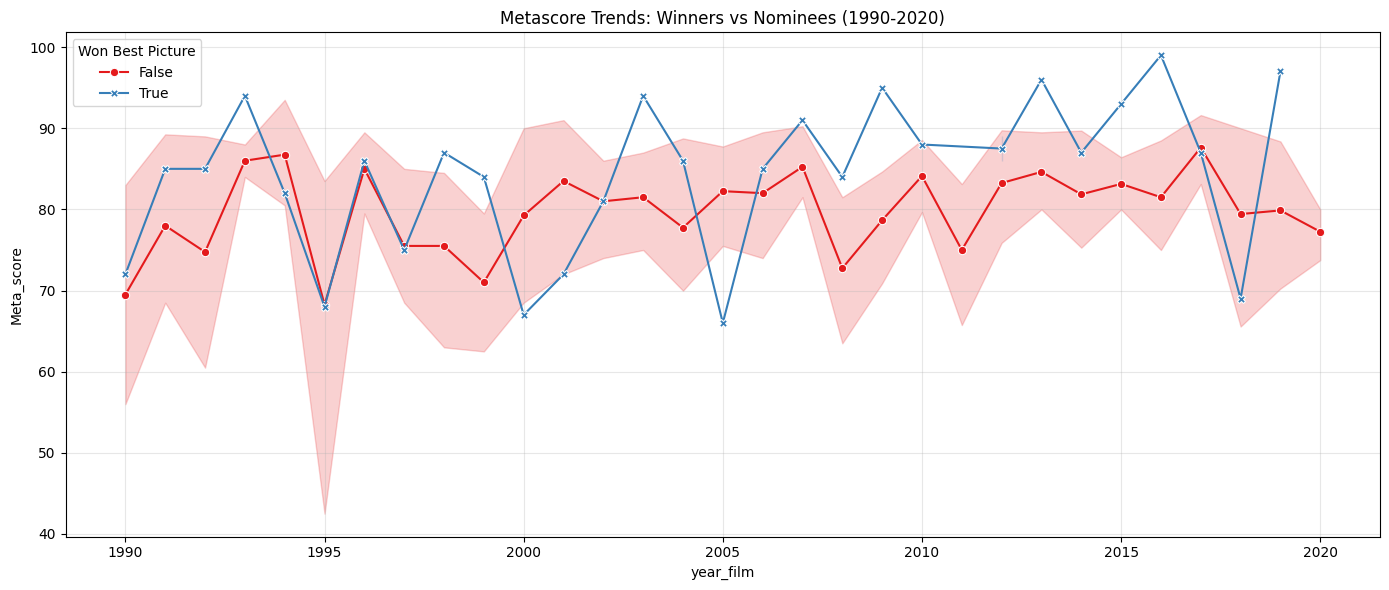

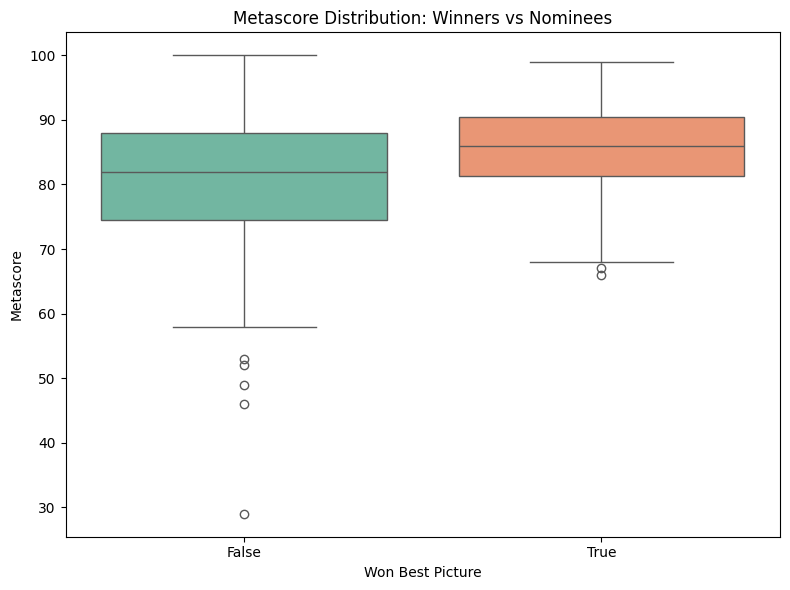

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import io
import warnings

# --- 0. Setup ---
# Suppress warnings to keep output clean
warnings.filterwarnings("ignore")

# --- 1. Data Loading ---
try:
    with open('Final_best_picture_data.csv', 'r') as f:
        lines = f.readlines()

    cleaned_lines = []
    for line in lines:
        line = line.strip()
        if not line: continue
        # Handle rows wrapped entirely in quotes
        if line.startswith('"') and line.endswith('"'):
            content = line[1:-1].replace('""', '"')
            cleaned_lines.append(content)
        else:
            cleaned_lines.append(line)

    df = pd.read_csv(io.StringIO("\n".join(cleaned_lines)))
except FileNotFoundError:
    print("Error: 'Final_best_picture_data.csv' not found. Please upload the file.")
    df = pd.DataFrame()

if not df.empty:
    # --- 2. Preprocessing ---
    df['year_film'] = pd.to_numeric(df['year_film'], errors='coerce')
    df['winner'] = df['winner'].astype(str).str.lower() == 'true'

    # Filter for analysis period (1990-2020)
    df_analysis = df[(df['year_film'] >= 1990) & (df['year_film'] <= 2020)].copy()

    # Ensure Meta_score is numeric and drop NaNs
    df_analysis['Meta_score'] = pd.to_numeric(df_analysis['Meta_score'], errors='coerce')
    df_analysis = df_analysis.dropna(subset=['Meta_score'])

    # --- 3. Paired T-Test Preparation (Winner vs Avg Loser per Year) ---
    paired_data = []
    unique_years = sorted(df_analysis['year_film'].unique())

    critic_favorite_wins = 0
    total_years_checked = 0

    for year in unique_years:
        year_data = df_analysis[df_analysis['year_film'] == year]

        # Check if year has at least one Winner AND at least one Loser
        if year_data['winner'].any() and (~year_data['winner']).any():
            # Get Winner Score
            winner_score = year_data[year_data['winner']]['Meta_score'].mean()
            # Get Average Score of Losers
            losers_avg_score = year_data[~year_data['winner']]['Meta_score'].mean()

            paired_data.append({
                'Year': year,
                'Winner_Score': winner_score,
                'Losers_Avg_Score': losers_avg_score
            })

        # --- Critic Favorite Calculation ---
        if not year_data.empty:
            max_score = year_data['Meta_score'].max()
            top_films = year_data[year_data['Meta_score'] == max_score]
            if top_films['winner'].any():
                critic_favorite_wins += 1
            total_years_checked += 1

    paired_df = pd.DataFrame(paired_data)

    # --- 4. Statistical Test ---
    print("==================================================")
    print("PART 1: PAIRED T-TEST RESULTS (Winner vs Field)")
    print("==================================================")

    if len(paired_df) > 1:
        t_stat, p_val = ttest_rel(paired_df['Winner_Score'], paired_df['Losers_Avg_Score'])

        print(f"Number of Years Analyzed:   {len(paired_df)}")
        print(f"Mean Winner Score:          {paired_df['Winner_Score'].mean():.2f}")
        print(f"Mean Loser (Avg) Score:     {paired_df['Losers_Avg_Score'].mean():.2f}")
        print(f"Average Difference:         +{paired_df['Winner_Score'].mean() - paired_df['Losers_Avg_Score'].mean():.2f} points")
        print(f"T-Statistic:                {t_stat:.4f}")
        print(f"P-Value:                    {p_val:.4f}")

        if p_val < 0.05:
            print("CONCLUSION: REJECT H0. The Best Picture winner consistently has a significantly higher Metascore than the average nominee in its year.")
        else:
            print("CONCLUSION: FAIL TO REJECT H0. There is no significant consistent difference.")
    else:
        print("Insufficient data to perform Paired T-Test (need at least 2 years with valid winner/loser data).")

    print("\n==================================================")
    print("PART 2: CRITIC FAVORITE ANALYSIS")
    print("==================================================")
    critic_fav_rate = critic_favorite_wins / total_years_checked if total_years_checked > 0 else 0
    print(f"Critic Favorite Win Rate: {critic_fav_rate:.1%}")
    print(f"Interpretation: In {critic_fav_rate:.1%} of cases, the film with the absolute highest Metacritic score won the Oscar.")

    # --- 5. Visualizations ---

    # Visualization A: Line Plot
    plt.figure(figsize=(14, 6))
    # Note: hue needs numeric or categorical, winner is bool (True/False).
    # We map boolean to string for cleaner plotting if needed, but bool works.
    sns.lineplot(data=df_analysis, x='year_film', y='Meta_score', hue='winner',
                 style='winner', markers=True, dashes=False, palette='Set1')
    plt.title('Metascore Trends: Winners vs Nominees (1990-2020)')
    plt.grid(True, alpha=0.3)
    plt.legend(title='Won Best Picture')
    plt.tight_layout()
    plt.show()

    # Visualization B: Box Plot (Distribution)
    plt.figure(figsize=(8, 6))

    # FIX: Assign 'x' to 'hue' to avoid FutureWarnings in new Seaborn
    # DO NOT pass 'legend=False' here as it breaks older Seaborn versions
    ax = sns.boxplot(x='winner', y='Meta_score', data=df_analysis, hue='winner', palette='Set2')

    # Manually remove the legend to avoid clutter (since x-axis labels are sufficient)
    if ax.legend_:
        ax.legend_.remove()

    plt.title('Metascore Distribution: Winners vs Nominees')
    plt.xlabel('Won Best Picture')
    plt.ylabel('Metascore')
    plt.tight_layout()
    plt.show()

ANALYSIS: Best Director Nomination vs Best Picture Win
Total Films Analyzed: 197

Group 1: Films WITH Best Director Nomination
  - Count:    127
  - Winners:  28
  - Win Rate: 22.0%

Group 2: Films WITHOUT Best Director Nomination
  - Count:    70
  - Winners:  2
  - Win Rate: 2.9%

-------------------------------------------------------
Chi-Square Test Results
-------------------------------------------------------
Chi-Square Statistic: 11.4295
P-Value:              0.0007

CONCLUSION: REJECT H0.
There is a statistically significant association between being nominated for Best Director and winning Best Picture.
Interpretation: A Best Director nomination is a crucial prerequisite; films without it rarely win.


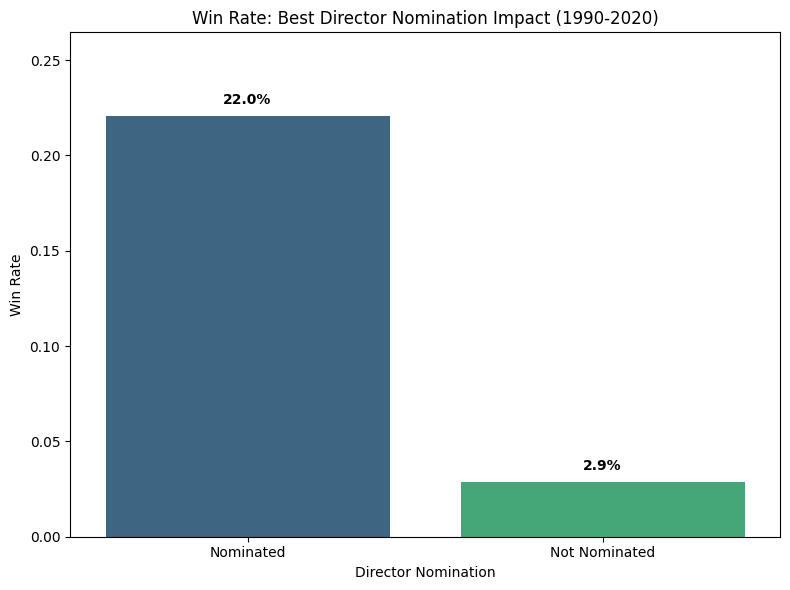

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import io
import warnings

# --- 0. Setup ---
# Suppress warnings for clean output
warnings.filterwarnings("ignore")

# --- 1. Data Loading ---
try:
    with open('Final_best_picture_data.csv', 'r') as f:
        lines = f.readlines()

    cleaned_lines = []
    for line in lines:
        line = line.strip()
        if not line: continue
        # Handle rows wrapped entirely in quotes
        if line.startswith('"') and line.endswith('"'):
            content = line[1:-1].replace('""', '"')
            cleaned_lines.append(content)
        else:
            cleaned_lines.append(line)

    df = pd.read_csv(io.StringIO("\n".join(cleaned_lines)))
except FileNotFoundError:
    print("Error: 'Final_best_picture_data.csv' not found.")
    df = pd.DataFrame()

if not df.empty:
    # --- 2. Preprocessing ---
    df['year_film'] = pd.to_numeric(df['year_film'], errors='coerce')
    df['winner'] = df['winner'].astype(str).str.lower() == 'true'

    # Filter for the project period (1990-2020)
    df_analysis = df[(df['year_film'] >= 1990) & (df['year_film'] <= 2020)].copy()

    # Create Feature: Nominated for Best Director
    # The column 'Nominated_Both_Director_and_Picture' implies the film has a Director nom.
    df_analysis['has_director_nom'] = df_analysis['Nominated_Both_Director_and_Picture'].astype(str).str.lower() == 'true'

    # --- 3. Chi-Square Test Analysis ---

    # Construct Contingency Table
    #                    Win   Lose
    # Director Nom        a      b
    # No Director Nom     c      d

    dir_nom_win = len(df_analysis[(df_analysis['has_director_nom']) & (df_analysis['winner'])])
    dir_nom_lose = len(df_analysis[(df_analysis['has_director_nom']) & (~df_analysis['winner'])])
    no_dir_nom_win = len(df_analysis[(~df_analysis['has_director_nom']) & (df_analysis['winner'])])
    no_dir_nom_lose = len(df_analysis[(~df_analysis['has_director_nom']) & (~df_analysis['winner'])])

    contingency_table = [[dir_nom_win, dir_nom_lose],
                         [no_dir_nom_win, no_dir_nom_lose]]

    # Perform Chi-Square Test of Independence
    chi2, p_val, dof, expected = chi2_contingency(contingency_table)

    # Calculate Win Rates for Reporting
    total_with_nom = dir_nom_win + dir_nom_lose
    rate_with_nom = dir_nom_win / total_with_nom if total_with_nom > 0 else 0

    total_without_nom = no_dir_nom_win + no_dir_nom_lose
    rate_without_nom = no_dir_nom_win / total_without_nom if total_without_nom > 0 else 0

    # Print Results
    print("=======================================================")
    print("ANALYSIS: Best Director Nomination vs Best Picture Win")
    print("=======================================================")
    print(f"Total Films Analyzed: {len(df_analysis)}")

    print(f"\nGroup 1: Films WITH Best Director Nomination")
    print(f"  - Count:    {total_with_nom}")
    print(f"  - Winners:  {dir_nom_win}")
    print(f"  - Win Rate: {rate_with_nom:.1%}")

    print(f"\nGroup 2: Films WITHOUT Best Director Nomination")
    print(f"  - Count:    {total_without_nom}")
    print(f"  - Winners:  {no_dir_nom_win}")
    print(f"  - Win Rate: {rate_without_nom:.1%}")

    print("\n-------------------------------------------------------")
    print("Chi-Square Test Results")
    print("-------------------------------------------------------")
    print(f"Chi-Square Statistic: {chi2:.4f}")
    print(f"P-Value:              {p_val:.4f}")

    if p_val < 0.05:
        print("\nCONCLUSION: REJECT H0.")
        print("There is a statistically significant association between being nominated for Best Director and winning Best Picture.")
        print("Interpretation: A Best Director nomination is a crucial prerequisite; films without it rarely win.")
    else:
        print("\nCONCLUSION: FAIL TO REJECT H0.")
        print("There is no statistically significant association.")

    # --- 4. Visualization ---
    # Prepare data for plotting
    plot_data = pd.DataFrame({
        'Director Nomination': ['Nominated', 'Not Nominated'],
        'Win Rate': [rate_with_nom, rate_without_nom]
    })

    plt.figure(figsize=(8, 6))

    # Create Bar Chart
    # Hue assigned to x variable to satisfy new Seaborn requirements
    ax = sns.barplot(x='Director Nomination', y='Win Rate', data=plot_data,
                     hue='Director Nomination', palette='viridis')

    # Add percentage labels on top of bars
    for i, rate in enumerate([rate_with_nom, rate_without_nom]):
        ax.text(i, rate + 0.005, f'{rate:.1%}', ha='center', va='bottom', fontweight='bold')

    plt.title('Win Rate: Best Director Nomination Impact (1990-2020)')
    plt.ylabel('Win Rate')
    plt.ylim(0, max(rate_with_nom, rate_without_nom) * 1.2) # Add headroom for labels

    # Manually handle legend if it appears (unnecessary here)
    if ax.legend_:
        ax.legend_.remove()

    plt.tight_layout()
    plt.show()

ANALYSIS: Golden Globe Win vs Best Picture Win
Total Films Analyzed: 197

Group 1: Films that WON a Golden Globe
  - Count:    48
  - Winners:  17
  - Win Rate: 35.4%

Group 2: Films that DID NOT Win a Golden Globe
  - Count:    149
  - Winners:  13
  - Win Rate: 8.7%

-------------------------------------------------------
Fisher's Exact Test Results
-------------------------------------------------------
Odds Ratio: 5.7370
P-Value:    0.0000

CONCLUSION: REJECT H0.
There is a statistically significant association between winning a Golden Globe and winning Best Picture.
Interpretation: Winning a Golden Globe drastically increases the odds of winning the Oscar.


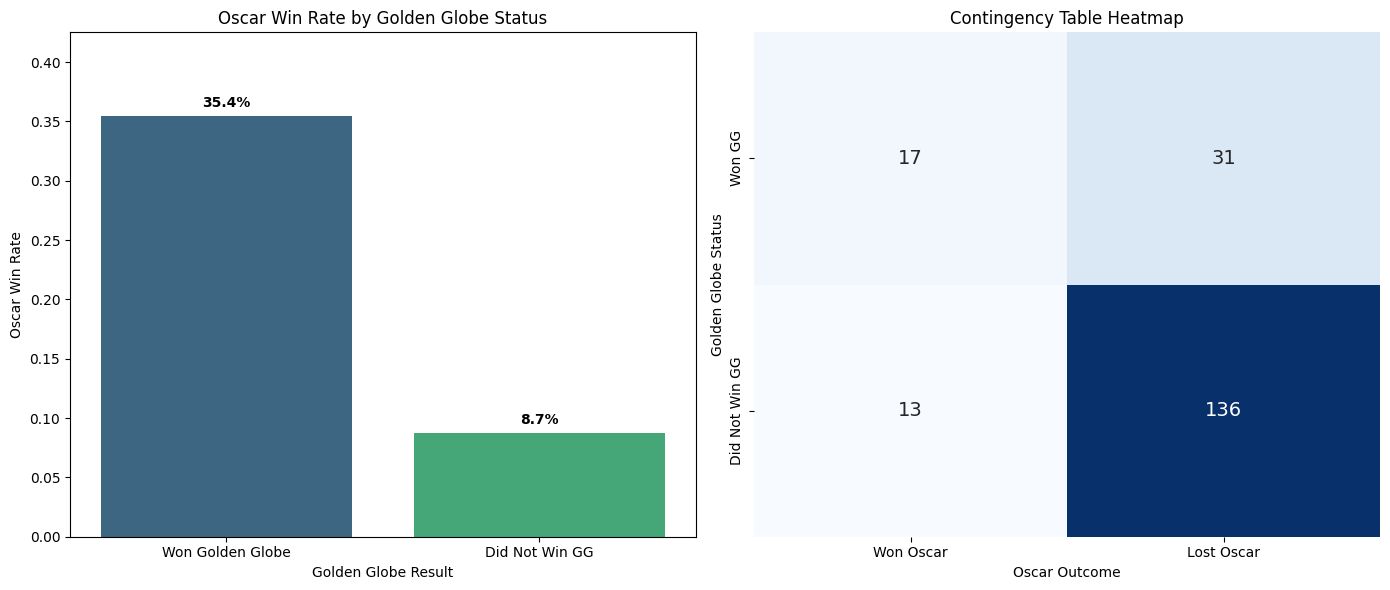

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
import io
import warnings

# --- 0. Setup ---
warnings.filterwarnings("ignore")

# --- 1. Data Loading ---
try:
    with open('Final_best_picture_data.csv', 'r') as f:
        lines = f.readlines()

    cleaned_lines = []
    for line in lines:
        line = line.strip()
        if not line: continue
        # Handle rows wrapped entirely in quotes
        if line.startswith('"') and line.endswith('"'):
            content = line[1:-1].replace('""', '"')
            cleaned_lines.append(content)
        else:
            cleaned_lines.append(line)

    df = pd.read_csv(io.StringIO("\n".join(cleaned_lines)))
except FileNotFoundError:
    print("Error: 'Final_best_picture_data.csv' not found.")
    df = pd.DataFrame()

if not df.empty:
    # --- 2. Preprocessing ---
    df['year_film'] = pd.to_numeric(df['year_film'], errors='coerce')
    df['winner'] = df['winner'].astype(str).str.lower() == 'true'

    # Filter for the project period (1990-2020)
    df_analysis = df[(df['year_film'] >= 1990) & (df['year_film'] <= 2020)].copy()

    # Feature: Won Golden Globe
    df_analysis['has_gg_win'] = df_analysis['Golden_Globe_Picture_Winner'].astype(str).str.lower() == 'true'

    # --- 3. Fisher's Exact Test Analysis ---

    # Contingency Table
    #                  Oscar Win   Oscar Lose
    # GG Win              a            b
    # GG Lose             c            d

    gg_win_oscar_win = len(df_analysis[(df_analysis['has_gg_win']) & (df_analysis['winner'])])
    gg_win_oscar_lose = len(df_analysis[(df_analysis['has_gg_win']) & (~df_analysis['winner'])])

    gg_lose_oscar_win = len(df_analysis[(~df_analysis['has_gg_win']) & (df_analysis['winner'])])
    gg_lose_oscar_lose = len(df_analysis[(~df_analysis['has_gg_win']) & (~df_analysis['winner'])])

    contingency_table = [[gg_win_oscar_win, gg_win_oscar_lose],
                         [gg_lose_oscar_win, gg_lose_oscar_lose]]

    # Fisher's Exact Test
    odds_ratio, p_val = fisher_exact(contingency_table, alternative='two-sided')

    # Calculate Win Rates
    total_gg_winners = gg_win_oscar_win + gg_win_oscar_lose
    rate_gg_win = gg_win_oscar_win / total_gg_winners if total_gg_winners > 0 else 0

    total_gg_losers = gg_lose_oscar_win + gg_lose_oscar_lose
    rate_gg_lose = gg_lose_oscar_win / total_gg_losers if total_gg_losers > 0 else 0

    # Print Results
    print("=======================================================")
    print("ANALYSIS: Golden Globe Win vs Best Picture Win")
    print("=======================================================")
    print(f"Total Films Analyzed: {len(df_analysis)}")

    print(f"\nGroup 1: Films that WON a Golden Globe")
    print(f"  - Count:    {total_gg_winners}")
    print(f"  - Winners:  {gg_win_oscar_win}")
    print(f"  - Win Rate: {rate_gg_win:.1%}")

    print(f"\nGroup 2: Films that DID NOT Win a Golden Globe")
    print(f"  - Count:    {total_gg_losers}")
    print(f"  - Winners:  {gg_lose_oscar_win}")
    print(f"  - Win Rate: {rate_gg_lose:.1%}")

    print("\n-------------------------------------------------------")
    print("Fisher's Exact Test Results")
    print("-------------------------------------------------------")
    print(f"Odds Ratio: {odds_ratio:.4f}")
    print(f"P-Value:    {p_val:.4f}")

    if p_val < 0.05:
        print("\nCONCLUSION: REJECT H0.")
        print("There is a statistically significant association between winning a Golden Globe and winning Best Picture.")
        print("Interpretation: Winning a Golden Globe drastically increases the odds of winning the Oscar.")
    else:
        print("\nCONCLUSION: FAIL TO REJECT H0.")
        print("There is no statistically significant association.")

    # --- 4. Visualization (Bar Chart + Heatmap) ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: Bar Chart
    plot_data = pd.DataFrame({
        'Golden Globe Result': ['Won Golden Globe', 'Did Not Win GG'],
        'Win Rate': [rate_gg_win, rate_gg_lose]
    })

    sns.barplot(x='Golden Globe Result', y='Win Rate', data=plot_data,
                hue='Golden Globe Result', palette='viridis', ax=axes[0])

    # Add percentage labels
    for i, rate in enumerate([rate_gg_win, rate_gg_lose]):
        axes[0].text(i, rate + 0.005, f'{rate:.1%}', ha='center', va='bottom', fontweight='bold')

    axes[0].set_title('Oscar Win Rate by Golden Globe Status')
    axes[0].set_ylabel('Oscar Win Rate')
    axes[0].set_ylim(0, max(rate_gg_win, rate_gg_lose) * 1.2)
    # Remove redundant legend
    if axes[0].legend_: axes[0].legend_.remove()

    # Plot 2: Heatmap of Contingency Table
    # Create DataFrame for better labeling in heatmap
    heatmap_data = pd.DataFrame(contingency_table,
                                index=['Won GG', 'Did Not Win GG'],
                                columns=['Won Oscar', 'Lost Oscar'])

    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False, annot_kws={"size": 14})
    axes[1].set_title('Contingency Table Heatmap')
    axes[1].set_ylabel('Golden Globe Status')
    axes[1].set_xlabel('Oscar Outcome')

    plt.tight_layout()
    plt.show()